In [1]:
import wandb
token="dbc1309d957850844048db2d2add36cbefe62171"
wandb.login(key=token)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: -10-30- (mohamedalaa00). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=8d4cc28d6f3e6f2582831bc00fe6a2f5f60bf9380641f1a194fae7de24d40380
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
from datasets import get_dataset_config_names
from datasets import load_dataset
from collections import defaultdict, Counter
from datasets import DatasetDict
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from transformers import XLMRobertaConfig, AutoConfig, AutoTokenizer, DataCollatorForTokenClassification, Trainer, TrainingArguments
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer, YosoForTokenClassification
from datasets import concatenate_datasets

In [4]:
def get_data():
    
    langs = ["de", "fr", "it", "en"]
    panx_ch = defaultdict(DatasetDict)
    
    for lang in langs:
        ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
        for split in ds: 
            panx_ch[lang][split] = ds[split].shuffle(seed=0)
        
    return panx_ch

panx_ch = get_data()

README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature

In [6]:
def create_tag_names(batch):
 return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}
panx_de = panx_ch["de"].map(create_tag_names)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
yoso_tokenizer = AutoTokenizer.from_pretrained("uw-madison/yoso-4096", add_prefix_space=True)

In [10]:
def tag_text(text, tags, model, tokenizer):
    """
    Tags a given text with predictions from a NER model.

    This function tokenizes the input text, runs it through a NER model, and 
    generates predictions for each token. The predictions are converted into 
    human-readable tag names, and the tokens and their corresponding tags are 
    returned as a pandas DataFrame.

    Args:
        text (str): The input text to be tagged.
        tags: A mapping or object containing tag names (e.g., `tags.names`).
        model: A pre-trained NER model that takes tokenized inputs and 
               outputs logits for each token.
        tokenizer: A tokenizer that splits the input text into tokens 
                   compatible with the model.
    
    Returns:
        pd.DataFrame: A DataFrame containing:
            - "Tokens": List of tokens from the input text.
            - "Tags": Predicted tags corresponding to each token.
    """
    tokens = tokenizer(text).tokens()
    input_ids = yoso_tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [11]:
def tokenize_and_align_labels(examples):
    """
    Tokenizes input sentences and aligns NER labels with tokenized outputs.

    This function uses a tokenizer that supports word-level tokenization and aligns 
    the NER tags to the subword tokenization scheme. It assigns `-100` to subword 
    tokens or special tokens to ensure they are ignored during the loss computation.

    Args:
        examples (dict): A dictionary containing:
            - "tokens" (list of list of str): Sentences represented as lists of tokens.
            - "ner_tags" (list of list of int): Corresponding NER tags for the tokens.

    Returns:
        dict: A dictionary containing:
            - Tokenized inputs (e.g., "input_ids", "attention_mask").
            - "labels": Aligned labels for the tokenized inputs.
    """
    tokenized_inputs = yoso_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [12]:
def encode_panx_dataset(corpus):
    """
    Encodes a PAN-X dataset by tokenizing the input sentences and aligning NER labels.

    This function applies the `tokenize_and_align_labels` function to the dataset using 
    batched processing, removing unnecessary columns (e.g., 'tokens', 'ner_tags', 'langs') 
    to prepare the dataset for model training.

    Args:
        corpus (DatasetDict): A `DatasetDict` object containing splits (e.g., 'train', 
                              'validation', 'test') with the features:
                              - "tokens": List of tokens for each sentence.
                              - "ner_tags": NER labels for the tokens.
                              - "langs": Language identifiers.

    Returns:
        DatasetDict: A `DatasetDict` with tokenized inputs and aligned labels, 
                     containing features such as "input_ids", "attention_mask", 
                     and "labels".
    """
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['tokens', 'ner_tags', 'langs'])

In [13]:
def align_predictions(predictions, label_ids):
    """
    Aligns model predictions with their corresponding labels, excluding ignored indices.

    This function processes batched model predictions and label IDs, converting them 
    into human-readable tag names while skipping indices marked with `-100` (ignored labels). 
    It ensures that predictions and labels are aligned at the token level.

    Args:
        predictions (numpy.ndarray): Array of shape `(batch_size, seq_len, num_labels)` 
                                     containing the model's logits for each token.
        label_ids (numpy.ndarray): Array of shape `(batch_size, seq_len)` containing 
                                   the true label IDs for each token, with `-100` 
                                   indicating ignored tokens.

    Returns:
        tuple: A pair of lists:
            - preds_list (list of list of str): Predicted tags for each example in the batch.
            - labels_list (list of list of str): True tags for each example in the batch.
    """
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
                
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list

In [14]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred), "precision":precision_score(y_true, y_pred),"recall":recall_score(y_true, y_pred)}

In [15]:
data_collator = DataCollatorForTokenClassification(yoso_tokenizer)

In [16]:
yoso_config = AutoConfig.from_pretrained("uw-madison/yoso-4096", num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

In [25]:
def model_init():
    return (YosoForTokenClassification.from_pretrained("uw-madison/yoso-4096", config=yoso_config).to(device))

In [18]:
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus


In [23]:
corpora = []
for lang in ["de", "fr", "it", "en"]:
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    corpora.append(ds_encoded)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [26]:
corpora_encoded = concatenate_splits(corpora)
num_epochs = 3
batch_size = 24
logging_steps = len(corpora_encoded["train"]) // batch_size
model_name = f"yoso-all"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, eval_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=False)
trainer = Trainer(model_init=model_init, args=training_args,
 data_collator=data_collator, compute_metrics=compute_metrics,
 tokenizer=yoso_tokenizer, train_dataset=corpora_encoded["train"],
 eval_dataset=corpora_encoded["validation"])
trainer.train()

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/fast_lsh_cumulation...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/fast_lsh_cumulation/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fast_lsh_cumulation...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module fast_lsh_cumulation...
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` pa

Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.267200,0.190056,0.832595,0.817443,0.848320
2,0.150400,0.172364,0.859612,0.853475,0.865837
3,0.094900,0.182364,0.869189,0.864213,0.874221


TrainOutput(global_step=10002, training_loss=0.1707764604471369, metrics={'train_runtime': 1711.8375, 'train_samples_per_second': 140.2, 'train_steps_per_second': 5.843, 'total_flos': 6081393487005408.0, 'train_loss': 0.1707764604471369, 'epoch': 3.0})

In [28]:
def get_f1_score(trainer, dataset):
 return trainer.predict(dataset).metrics["test_f1"]

In [30]:
f1_scores = defaultdict(dict)

In [31]:
langs=["de", "fr", "it", "en"]
for idx, lang in enumerate(langs):
 f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
    
scores_data = {"all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
 inplace=True)
f1_scores_df

Evaluated on,de,en,fr,it
Fine-tune on,,,,
all,0.8564,0.8345,0.8873,0.8932


In [32]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    return {"predicted_label": predicted_label}

In [33]:
test_set_corpa = corpora_encoded["test"]
test_set_corpa = test_set_corpa.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set_corpa.to_pandas()

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [35]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
 lambda x: yoso_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
 lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
 lambda x: [index2tag[i] for i in x])
df['predicted_label'] = df.apply(
 lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head(7)


,input_ids,attention_mask,labels,predicted_label,input_tokens
0,2585,1,B-LOC,B-LOC,ĠCon
0,2269,1,I-LOC,I-LOC,Ġdi
0,1777,1,I-LOC,I-LOC,ĠLake
0,36,1,I-LOC,I-LOC,Ġ(
0,886,1,I-LOC,I-LOC,ĠCalifornia
0,4839,1,I-LOC,I-LOC,Ġ)
0,111,1,O,O,Ġ-


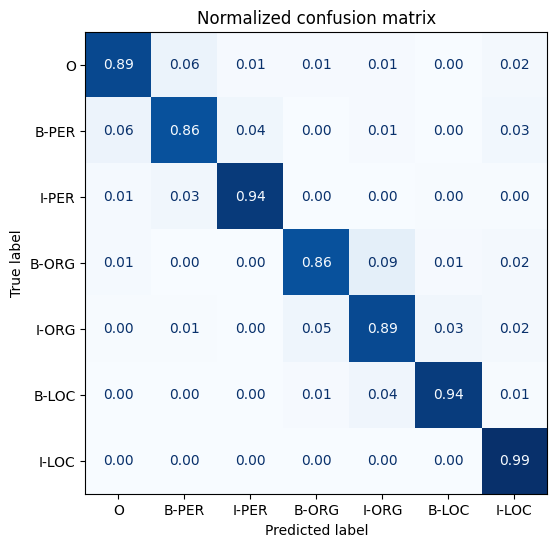

In [36]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],tags.names)